In [1]:
import glob
import os
import nibabel as nib
import numpy as np
from scipy.ndimage.interpolation import zoom
from scipy import ndimage
import pickle
import nibabel as nib
import random
from scipy.ndimage.interpolation import zoom
import copy
import Levenshtein

from torchvision import transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchcontrib.optim import SWA

from mutant_cla_network import *
from utility_func import *

%matplotlib inline

/share/apps/python3/3.6.3/intel/lib/python3.6/site-packages/h5py-2.7.1-py3.6-linux-x86_64.egg/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
mutant_names = read_mutant_txt('mutant_imgs.txt')
data_base_path = '/scratch/zq415/grammar_cor/mutant_detect/data'
# data_folder_list = ['20180419_newdata_nii_with_filtered', 'new_data_20180522_nii', 'organized_data_nii']

In [ ]:
# mutant_label[i] = (i, 1, bv_base_name, label_resized, img_resized, img_path[1])

save_name = 'All_unalign_bv_body_data_128_128_128_down.pickle' #All_body_data_128_98_80_down, All_data_256_196_160_down, All_bv_data_64_64_40_down
# All_unalign_bv_body_data_128_128_128_down, All_unalign_bv_data_64_64_64_down
cross_group_name = 'fold_name_6.pickle'
with open(os.path.join(os.getcwd(),'data',save_name), "rb") as input_file:
    all_train_data = pickle.load(input_file)
    
with open(os.path.join(os.getcwd(),'data',cross_group_name), "rb") as input_file:
    data_folds = pickle.load(input_file)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_epochs = 300
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor([3.5,1.0]).to(device))


for fold_num in range(6):
#     if fold_num != 5:
#         continue   
    net = VGG_net()
    #net.apply(weight_init)
    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        net = nn.DataParallel(net)
    net.to(device)
    print("There are {} parameters in the model".format(count_parameters(net)))
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.00001)
    optimizer = SWA(optimizer, swa_start=200, swa_freq=5)
    print('choose SGD as optimizer')
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=140, gamma=0.5)
    
    train_data = []
    test_data = []
    used_name_list = []
    test_mut_num = 0
    train_mut_num = 0
    for current_fold in range(6):
        if current_fold == fold_num:
            for i in range(len(data_folds[current_fold])):
                if data_folds[current_fold][i][0] in all_train_data and data_folds[current_fold][i][0] not in used_name_list:
                    cur_img = all_train_data[data_folds[current_fold][i][0]]
                    test_data.append((cur_img - 0.5, data_folds[current_fold][i][1]))
                    used_name_list.append(data_folds[current_fold][i][0])
                    if data_folds[current_fold][i][1] == 0:
                        test_mut_num += 1
        else:
            for i in range(len(data_folds[current_fold])):
                if data_folds[current_fold][i][0] in all_train_data and data_folds[current_fold][i][0] not in used_name_list:
                    cur_img = all_train_data[data_folds[current_fold][i][0]]
                    train_data.append((cur_img - 0.5, data_folds[current_fold][i][1]))
                    used_name_list.append(data_folds[current_fold][i][0])
                    if data_folds[current_fold][i][1] == 0:
                        train_mut_num += 1
                                 
    print('current fold: ', fold_num, 'test_data_len: ', len(test_data), 'train_data_len: ', len(train_data),
         'total len: ', len(test_data)+len(train_data))
    print('test_mut_num: ', test_mut_num, 'train_mut_num: ', train_mut_num)
                                 
    for epoch in range(num_epochs):
        scheduler.step()

        Mouse_dataset = Mouse_sub_volumes(train_data, transform=transforms.Compose([Rotate(), Flip()]))
        dataloader = DataLoader(Mouse_dataset, batch_size=8, shuffle=True, num_workers=4, drop_last = True)
        train(net, device, dataloader, optimizer, criterion, epoch)
        if (epoch + 1) % 10 == 0:
            print('fold {}, epoch {} train accuracy: '.format(fold_num, epoch+1))
            train_Mouse_dataset = Mouse_sub_volumes(train_data)
            train_dataloader = DataLoader(train_Mouse_dataset, batch_size=1, shuffle=False, num_workers=4)
            train_dic = test(net, device, train_dataloader)
            get_confusion_matrix(train_dic)

            print("-------------------")
            print('fold {}, epoch {} test accuracy: '.format(fold_num, epoch+1))
            test_Mouse_dataset = Mouse_sub_volumes(test_data)
            test_dataloader = DataLoader(test_Mouse_dataset, batch_size=1, shuffle=False, num_workers=4)
            test_dic = test(net, device, test_dataloader)
            get_confusion_matrix(test_dic)

            torch.save(net.state_dict(), './model/mut_clas_2020_03_20_e{}_global3_fold{}_raw_bv_test.pth'.format(epoch+1,fold_num))
            
    del net, optimizer, scheduler

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
test_results = []

for fold_num in range(6):
    net = VGG_net()
    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        net = nn.DataParallel(net)
    net.to(device)
    print("There are {} parameters in the model".format(count_parameters(net)))
    
    if fold_num <= 3:
        net.load_state_dict(torch.load('./model/mut_clas_2020_03_20_e400_global3_fold{}_raw_bv_body.pth'.format(fold_num)))
    else:
        net.load_state_dict(torch.load('./model/mut_clas_2020_03_23_e400_global3_fold{}_raw_bv_body.pth'.format(fold_num)))
    ##map_location=torch.device('cpu')
    #net.apply(weight_init)
    train_data = []
    test_data = []
    used_name_list = []
    test_mut_num = 0
    train_mut_num = 0
    for current_fold in range(6):
        if current_fold == fold_num:
            for i in range(len(data_folds[current_fold])):
                if data_folds[current_fold][i][0] in all_train_data and data_folds[current_fold][i][0] not in used_name_list:
                    cur_img = all_train_data[data_folds[current_fold][i][0]]
                    test_data.append((cur_img - 0.5, data_folds[current_fold][i][1]))
                    used_name_list.append(data_folds[current_fold][i][0])
                    if data_folds[current_fold][i][1] == 0:
                        test_mut_num += 1
        else:
            for i in range(len(data_folds[current_fold])):
                if data_folds[current_fold][i][0] in all_train_data and data_folds[current_fold][i][0] not in used_name_list:
                    cur_img = all_train_data[data_folds[current_fold][i][0]]
                    train_data.append((cur_img - 0.5, data_folds[current_fold][i][1]))
                    used_name_list.append(data_folds[current_fold][i][0])
                    if data_folds[current_fold][i][1] == 0:
                        train_mut_num += 1
                                 
    print('current fold: ', fold_num, 'test_data_len: ', len(test_data), 'train_data_len: ', len(train_data),
         'total len: ', len(test_data)+len(train_data))
    print('test_mut_num: ', test_mut_num, 'train_mut_num: ', train_mut_num)
                                 
    print('fold {} test accuracy: '.format(fold_num))
    test_Mouse_dataset = Mouse_sub_volumes(test_data)
    test_dataloader = DataLoader(test_Mouse_dataset, batch_size=1, shuffle=False, num_workers=4)
    test_dic = test_with_probability(net, device, test_dataloader)
    
    y_test = []
    y_score = []
    for i in range(len(test_dic)):
        y_test.append(1 - test_dic[i][0][0])
        y_score.append(test_dic[i][2])
        
    test_results.append((y_test, y_score))
    
    del net, test_dataloader

In [2]:
with open('./data/cross_test_result.pickle','rb') as input_file:
    bv_body_test_results = pickle.load(input_file)
    
with open('./data/body_cross_test_result.pickle','rb') as input_file:
    body_test_results = pickle.load(input_file)
    
with open('./data/bv_cross_test_result.pickle','rb') as input_file:
    bv_test_results = pickle.load(input_file)

# with open('./data/raw_bv_cross_test_result.pickle','rb') as input_file:
#     raw_bv_test_results = pickle.load(input_file)
    
with open('./data/raw_bv_body_cross_test_result.pickle','rb') as input_file:
    raw_bv_body_test_results = pickle.load(input_file)

In [3]:
# save_file = open('./data/raw_bv_body_cross_test_result.pickle','wb')
# pickle.dump(test_results, save_file)
# save_file.close()

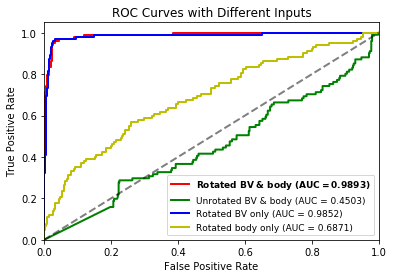

In [74]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc

combine_true_bv_body = []
combine_predic_bv_body = []
for i in range(len(bv_body_test_results)):
    combine_true_bv_body += bv_body_test_results[i][0]
    combine_predic_bv_body += bv_body_test_results[i][1]
    
combine_true_body = []
combine_predic_body = []
for i in range(len(body_test_results)):
    combine_true_body += body_test_results[i][0]
    combine_predic_body += body_test_results[i][1]
    
combine_true_bv = []
combine_predic_bv = []
for i in range(len(bv_test_results)):
    combine_true_bv += bv_test_results[i][0]
    combine_predic_bv += bv_test_results[i][1]
    
# combine_true_raw_bv = []
# combine_predic_raw_bv = []
# for i in range(len(raw_bv_test_results)):
#     combine_true_raw_bv += raw_bv_test_results[i][0]
#     combine_predic_raw_bv += raw_bv_test_results[i][1]
    
combine_true_raw_bv_body = []
combine_predic_raw_bv_body = []
for i in range(len(raw_bv_body_test_results)):
    combine_true_raw_bv_body += raw_bv_body_test_results[i][0]
    combine_predic_raw_bv_body += raw_bv_body_test_results[i][1]

    
fpr_bv_body, tpr_bv_body, _ = roc_curve(np.array(combine_true_bv_body), np.array(combine_predic_bv_body))
roc_auc_bv_body = auc(fpr_bv_body, tpr_bv_body)

fpr_body, tpr_body, _ = roc_curve(np.array(combine_true_body), np.array(combine_predic_body))
roc_auc_body = auc(fpr_body, tpr_body)

fpr_bv, tpr_bv, _ = roc_curve(np.array(combine_true_bv), np.array(combine_predic_bv))
roc_auc_bv = auc(fpr_bv, tpr_bv)

# fpr_raw_bv, tpr_raw_bv, _ = roc_curve(np.array(combine_true_raw_bv), np.array(combine_predic_raw_bv))
# roc_auc_raw_bv = auc(fpr_raw_bv, tpr_raw_bv)

fpr_raw_bv_body, tpr_raw_bv_body, _ = roc_curve(np.array(combine_true_raw_bv_body), np.array(combine_predic_raw_bv_body))
roc_auc_raw_bv_body = auc(fpr_raw_bv_body, tpr_raw_bv_body)

plt.figure()
lw = 2
plt.plot(fpr_bv_body, tpr_bv_body, color='r', 
         lw=lw, label=r"$\bf{Rotated}$ $\bf{BV}$ $\bf{&}$ $\bf{body}$ $\bf{(AUC = 0.9893)}$")

plt.plot(fpr_raw_bv_body, tpr_raw_bv_body, color='g', 
         lw=lw, label='Unrotated BV & body (AUC = %0.4f)' % roc_auc_raw_bv_body)

plt.plot(fpr_bv, tpr_bv, color='b',
         lw=lw, label='Rotated BV only (AUC = %0.4f)' % roc_auc_bv)

# plt.plot(fpr_raw_bv, tpr_raw_bv, color='c', 
#          lw=lw, label='Unrotated BV only (area = %0.4f)' % roc_auc_raw_bv)

plt.plot(fpr_body, tpr_body, color='y', 
         lw=lw, label='Rotated body only (AUC = %0.4f)' % roc_auc_body)


plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--', alpha = 0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves with Different Inputs')
plt.legend(loc="lower right", fontsize=9)
plt.savefig("./img/roc_curve2.jpg", dpi=500)
# plt.show()
# plt.savefig('./img/roc_curve.png')

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
test_results = []

for fold_num in range(6):
    net = VGG_net()
    net.load_state_dict(torch.load('./model/mut_clas_2020_03_11_e100_global3_fold{}.pth'.format(fold_num),map_location=torch.device('cpu')))
    #net.apply(weight_init)
    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        net = nn.DataParallel(net)
    net.to(device)
    print("There are {} parameters in the model".format(count_parameters(net)))
    
    train_data = []
    test_data = []
    used_name_list = []
    test_mut_num = 0
    train_mut_num = 0
    for current_fold in range(6):
        if current_fold == fold_num:
            for i in range(len(data_folds[current_fold])):
                if data_folds[current_fold][i][0] in all_train_data and data_folds[current_fold][i][0] not in used_name_list:
                    test_data.append((all_train_data[data_folds[current_fold][i][0]] - 1.0, data_folds[current_fold][i][1]))
                    used_name_list.append(data_folds[current_fold][i][0])
                    if data_folds[current_fold][i][1] == 0:
                        test_mut_num += 1
        else:
            for i in range(len(data_folds[current_fold])):
                if data_folds[current_fold][i][0] in all_train_data and data_folds[current_fold][i][0] not in used_name_list:
                    train_data.append((all_train_data[data_folds[current_fold][i][0]] - 1.0, data_folds[current_fold][i][1]))
                    used_name_list.append(data_folds[current_fold][i][0])
                    if data_folds[current_fold][i][1] == 0:
                        train_mut_num += 1
                                 
    print('current fold: ', fold_num, 'test_data_len: ', len(test_data), 'train_data_len: ', len(train_data),
         'total len: ', len(test_data)+len(train_data))
    print('test_mut_num: ', test_mut_num, 'train_mut_num: ', train_mut_num)
                                 
    test_Mouse_dataset = Mouse_sub_volumes(test_data)
    test_dataloader = DataLoader(test_Mouse_dataset, batch_size=1, shuffle=False, num_workers=4)
    
    for i_batch, sample_batched in enumerate(test_dataloader):
        inputs, labels = sample_batched['image'], sample_batched['label']  
        inputs = inputs.to(device)
        labels = labels.to(device)
        saliency = compute_saliency_maps(inputs, labels, net, device)

        max_value = torch.max(saliency)
        print(torch.max(saliency), torch.min(saliency))
        saliency[saliency >= (max_value*0.2)] = 100
        saliency[saliency < (max_value*0.2)] = 0
        saliency *= 0.01
        print('working on fold {}, image {}'.format(fold_num, i_batch))

        img_nft = nib.Nifti1Image(np.squeeze(inputs.cpu().detach().numpy()+1.0),np.eye(4))
        img_save_data_path = './saliency_map/img_label{}_fold{}_{}.nii'.format(labels.cpu().numpy()[0], fold_num, i_batch)
        nib.save(img_nft,img_save_data_path)

        print(i_batch, ' saliency num: ', np.sum(saliency.cpu().numpy()))
        saliency_nft = nib.Nifti1Image(np.squeeze(saliency.cpu().numpy()),np.eye(4))
        saliency_save_data_path = './saliency_map/salency_label{}_fold{}_{}.nii'.format(labels.cpu().numpy()[0], fold_num, i_batch)
        nib.save(saliency_nft,saliency_save_data_path)

    del net, test_dataloader

In [ ]:
# cam represent class saliency map
def compute_cam_maps(X, y, model, fc_weight, feature_extract): 
    model.eval()
    
    outputs = feature_extract(X).squeeze()
    channels = outputs.shape[0]
    saliency = outputs[0,...] * fc_weight[y, 0]
    for i in range(1,channels):
        saliency += outputs[i,...] * fc_weight[y, i]
    saliency = zoom(saliency.numpy(), 8)
    
    saliency = saliency - np.min(saliency)
    saliency = saliency / np.max(saliency)
    
    return saliency

In [ ]:
for i in range(1,96):
    print(i)

In [ ]:
net.cpu()
net.eval()

fc_weight = net.fc1.weight.data

res50_conv = nn.Sequential(*list(net.children())[:-2])
for param in res50_conv.parameters():
    param.requires_grad = False

test_Mouse_dataset = Mouse_sub_volumes(test_data)
test_dataloader = DataLoader(test_Mouse_dataset, batch_size=1, shuffle=False, num_workers=4)

for i_batch, sample_batched in enumerate(test_dataloader):
    inputs, labels = sample_batched['image'], sample_batched['label']
    print(res50_conv(inputs).shape)